In [1]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

## 토크나이저 테스트

In [4]:
test_sentence = "안녕하세요, 반갑습니다."

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
['[ C L S ]', '안', '# # 녕', '# # 하', '# # 세', '# # 요', ',', '반', '# # 갑', '# # 습', '# # 니 다', '.', '[ S E P ]']


In [5]:
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")
kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
# [101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
print(eng_encode)
# [101, 31178, 11356, 102]
print(kor_decode)
# [CLS] 안녕하세요, 반갑습니다 [SEP]
print(eng_decode)
# [CLS] Hello world [SEP]

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] Hello world [SEP]


In [6]:
DATA_PATH = os.path.join(DATA_IN_PATH, "hotel", "hotel_review.xlsx")

data = pd.read_excel(DATA_PATH, engine='openpyxl')

In [7]:
data = data.dropna()
data.head()

,label,review
0,0,리뷰 믿을만한게 아니에요 금액에비해 리뷰가 너무 좋아 예약했는데 일단 친철과 청결...
1,1,깨끗하고 편히쉬다갑니다
2,1,다 좋았는데 화장실 시설이 분리되어 있는게 불편했습니다
3,1,가격대비 좋더라구요 자주이용할게요
4,1,조식은 간단한 메뉴들인데 특별하게도 흰죽이 참 맛있었습니다서울에서 주말에 호텔이란 ...


In [8]:
reviews = list(data['review'])

In [9]:
tokenized_reviews = [r.split() for r in reviews]

In [10]:
review_len_by_token = [len(t) for t in tokenized_reviews]

In [13]:
review_len_by_eumjeol = [len(s.replace(' ', '')) for s in reviews]

Text(0, 0.5, 'Number of Reviews')

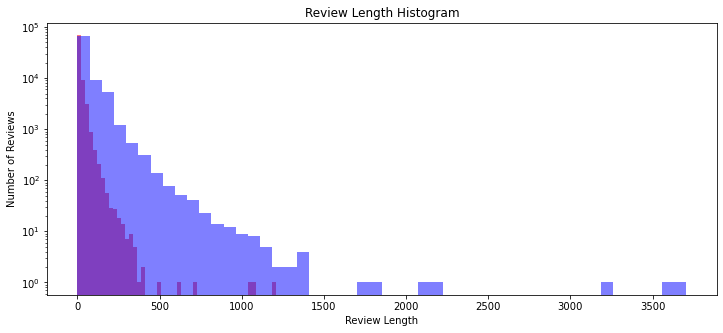

In [14]:
# figsize: (가로, 세로)
plt.figure(figsize=(12, 5))

# histogram
# bins: 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(review_len_by_token, bins=50, alpha=0.5, color= 'r', label='word')
plt.hist(review_len_by_eumjeol, bins=50, alpha=0.5, color='b', label='alphabet')
plt.yscale('log', nonposy='clip')

# 그래프 제목
plt.title('Review Length Histogram')

# 그래프 x 축 라벨
plt.xlabel('Review Length')

# 그래프 y 축 라벨
plt.ylabel('Number of Reviews')

In [15]:
print('문장 최대길이: {}'.format(np.max(review_len_by_token)))
print('문장 최소길이: {}'.format(np.min(review_len_by_token)))
print('문장 평균길이: {:.2f}'.format(np.mean(review_len_by_token)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(review_len_by_token)))
print('문장 중간길이: {}'.format(np.median(review_len_by_token)))

# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 길이: {}'.format(np.percentile(review_len_by_token, 25)))
print('제 3 사분위 길이: {}'.format(np.percentile(review_len_by_token, 75)))

문장 최대길이: 1208
문장 최소길이: 0
문장 평균길이: 14.58
문장 길이 표준편차: 22.44
문장 중간길이: 7.0
제 1 사분위 길이: 4.0
제 3 사분위 길이: 16.0


In [33]:
MAX_LEN = 20 # EDA에서 추출된 3분위 길이

{'boxes': [<matplotlib.lines.Line2D at 0x184b3b28e08>],
 'caps': [<matplotlib.lines.Line2D at 0x184b3b0bf88>,
 'fliers': [<matplotlib.lines.Line2D at 0x184b39f7d48>],
 'means': [<matplotlib.lines.Line2D at 0x184b39f78c8>],
 'medians': [<matplotlib.lines.Line2D at 0x184b39f75c8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x184b3b0f048>,
  <matplotlib.lines.Line2D at 0x184b3998e08>]}

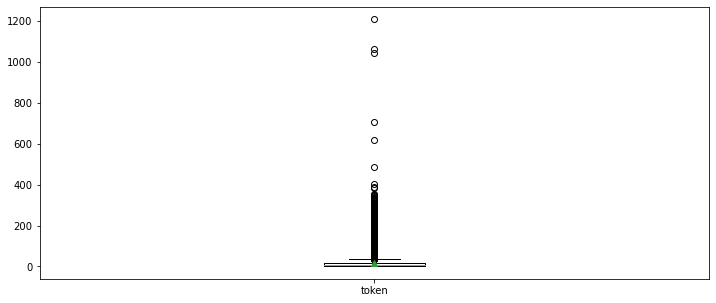

In [16]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([review_len_by_token],labels=['token'],showmeans=True)

{'boxes': [<matplotlib.lines.Line2D at 0x184b3a8ad88>],
 'caps': [<matplotlib.lines.Line2D at 0x184b3ad29c8>,
 'fliers': [<matplotlib.lines.Line2D at 0x184b3aa6248>],
 'means': [<matplotlib.lines.Line2D at 0x184b3aa67c8>],
 'medians': [<matplotlib.lines.Line2D at 0x184b3aa6508>],
 'whiskers': [<matplotlib.lines.Line2D at 0x184b3a96b88>,
  <matplotlib.lines.Line2D at 0x184b3ae1b08>]}

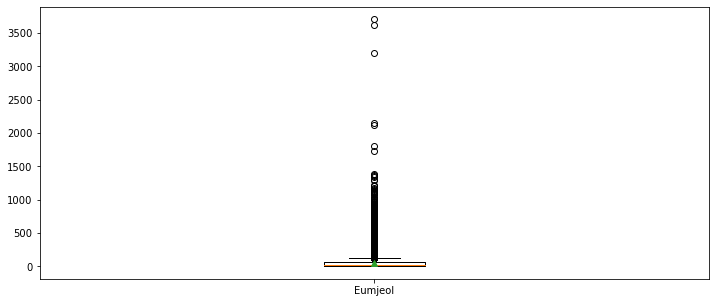

In [17]:
plt.figure(figsize=(12, 5))
plt.boxplot([review_len_by_eumjeol], labels=['Eumjeol'], showmeans=True)

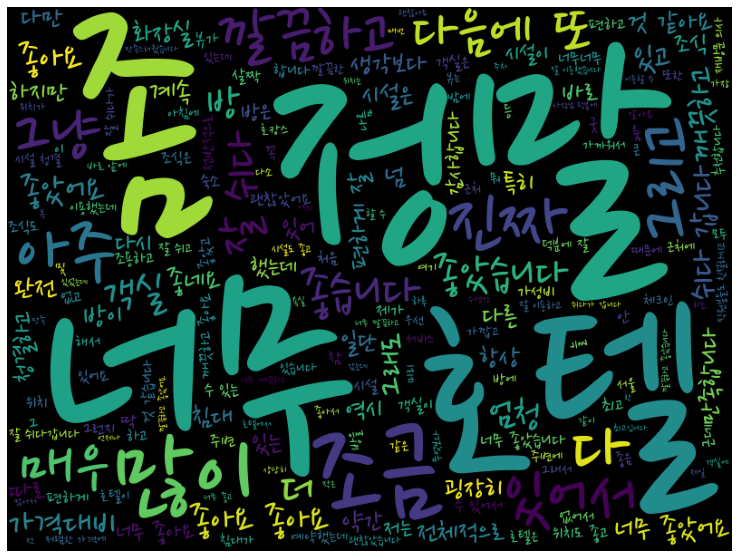

In [20]:
wordcloud = WordCloud(font_path='E:\\AI\\tensorflow-ml-nlp-tf2\\NanumPen.ttf', stopwords = STOPWORDS, background_color = 'black', width = 800, height = 600).generate(' '.join(data['review']))

plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

c:\users\seaofglass\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


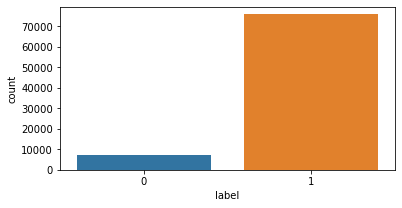

In [22]:
import seaborn as sns

label = data['label'].value_counts()
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(data['label'])

In [23]:
label

1    75849
0     7011
Name: label, dtype: int64

In [24]:
len(data)

82860

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['label'], test_size=0.2, random_state=7)

In [27]:
len(X_train) # review

66288

In [28]:
len(y_train) # label

66288

In [29]:
len(X_test) # test review data

16572

In [30]:
len(y_test) # test label

16572

In [31]:
# 스페셜 토큰
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# 토크나이저 테스트하기
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[UNK]', '[PAD]', '[SEP]', '[MASK]', '[CLS]'] 
 [100, 0, 102, 103, 101]
[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다. [SEP]
[CLS] Hello world [SEP]


In [34]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True,   # Construct attn. masks.
        truncation=True
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [35]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(X_train, y_train), total=len(data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_input_ids), len(train_data_labels)))

 80%|████████████████████████████████████████████████████████████▊               | 66288/82860 [00:39<00:09, 1681.06it/s]


# sents: 66288, # labels: 66288


In [36]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(X_test, y_test)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_input_ids), len(test_data_labels)))

16572it [00:09, 1690.63it/s]

num sents, labels 16572, 16572


In [37]:
# review 3분위 길이: 20
input_id = train_input_ids[1]
attention_mask = train_attention_masks[1]
token_type_id = train_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101   9599 119229   9625  25549  12178   9985 119290  12605   9663
  12092   9954  35465   9960  30005  11664   9495  12965  12424    102]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[CLS] 요즘 유행하는 호캉스 저도 한번 해보고 싶어서 [SEP]


In [38]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs : # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=2)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [39]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [40]:
model_name = "hotel_bert"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=1)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'hotel_bert_weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

print(history.history)

data_out/KOR\hotel_bert -- Folder create complete 

Epoch 1/3
1658/1658 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9160
Epoch 00001: val_accuracy improved from -inf to 0.91816, saving model to data_out/KOR\hotel_bert\hotel_bert_weights.h5
1658/1658 [==============================] - 8536s 5s/step - loss: 0.2351 - accuracy: 0.9160 - val_loss: 0.2086 - val_accuracy: 0.9182
Epoch 2/3
1658/1658 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9204
Epoch 00002: val_accuracy improved from 0.91816 to 0.92601, saving model to data_out/KOR\hotel_bert\hotel_bert_weights.h5
1658/1658 [==============================] - 8505s 5s/step - loss: 0.2055 - accuracy: 0.9204 - val_loss: 0.2164 - val_accuracy: 0.9260
Epoch 3/3
1658/1658 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9292
Epoch 00003: val_accuracy did not improve from 0.92601
1658/1658 [==============================] - 8458s 5s/step - loss: 0.1847 - accuracy: 0.929

In [42]:
cls_model.save_weights('hotel_bert_finetuning_weights.h5')

In [43]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

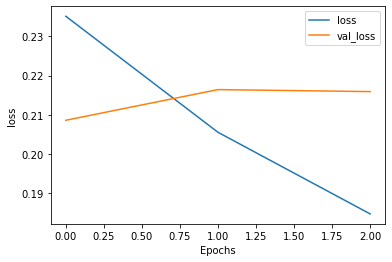

In [44]:
plot_graphs(history, 'loss')

In [45]:
results = cls_model.evaluate(test_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

17/17 [==============================] - 454s 27s/step - loss: 0.2150 - accuracy: 0.9213
test loss, test acc:  [0.2150246798992157, 0.9213130474090576]
